In [215]:
import networkx as nx
from sklearn import preprocessing
from collections import defaultdict
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score, average_precision_score
import math

import random
import numpy as np
seed = 42
random.seed(seed)
np.random.seed(seed)

In [216]:
def mask_test_edges(adj):
    # Function to build test set with 10% positive links

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    adj_triu = sp.triu(adj)
    adj_tuple = sparse_to_tuple(adj_triu)
    edges = adj_tuple[0]
    edges_all = sparse_to_tuple(adj)[0]
    num_test = int(np.floor(edges.shape[0] / 10.))
    num_val = int(np.floor(edges.shape[0] / 20.))



    all_edge_idx = list(range(edges.shape[0]))
    np.random.shuffle(all_edge_idx)
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
    test_edges = edges[test_edge_idx]
    val_edges = edges[val_edge_idx]
    train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)

    def ismember(a, b, tol=5):
        rows_close = np.all(np.round(a - b[:, None], tol) == 0, axis=-1)
        return np.any(rows_close)

    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], edges_all):
            continue
        if test_edges_false:
            if ismember([idx_j, idx_i], np.array(test_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(test_edges_false)):
                continue
        test_edges_false.append([idx_i, idx_j])

    val_edges_false = []
    while len(val_edges_false) < len(val_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], train_edges):
            continue
        if ismember([idx_j, idx_i], train_edges):
            continue
        if ismember([idx_i, idx_j], val_edges):
            continue
        if ismember([idx_j, idx_i], val_edges):
            continue
        if val_edges_false:
            if ismember([idx_j, idx_i], np.array(val_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(val_edges_false)):
                continue
        val_edges_false.append([idx_i, idx_j])

    data = np.ones(train_edges.shape[0])

    # Re-build adj matrix
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false

def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    # return sparse_to_tuple(adj_normalized)
    return sparse_mx_to_torch_sparse_tensor(adj_normalized)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def get_roc_score(emb, adj_orig, edges_pos, edges_neg):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

In [217]:
"""
This file contains the modules of Graph VAE model.
The code from - https://github.com/zfjsail/gae-pytorch is adapted.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter
import torch.nn.modules.loss
from torch import optim

import numpy as np
import pathlib
from pathlib import Path

import logging
import json


def loss_function(preds, labels, mu, logvar, n_nodes, norm, pos_weight):
    cost = norm * F.binary_cross_entropy_with_logits(preds, labels, pos_weight=pos_weight)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    logvar = torch.nn.functional.normalize(logvar,dim=1)
    KLD = -0.5 / n_nodes * torch.mean(torch.sum(
        1 + 2 * logvar - mu.pow(2) - logvar.exp().pow(2), 1))
#     print("KLD", KLD)
    # return cost
    return cost + KLD

class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, dropout=0., act=F.relu):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.act = act
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, input, adj):
        input = F.dropout(input, self.dropout, self.training)
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        output = self.act(output)
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class EncoderCora(nn.Module):
    def __init__(self, input_feat_dim, hidden_dim1=4, hidden_dim2=4, dropout=0):
        super(EncoderCora, self).__init__()
        self.gc1 = GraphConvolution(input_feat_dim, hidden_dim1, dropout, act=F.relu)
        self.gc2 = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=lambda x: x)
        self.gc3 = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=lambda x: x)
        
    def forward(self, x, adj):
        hidden1 = self.gc1(x, adj)
        mu, logvar = self.gc2(hidden1, adj), self.gc3(hidden1, adj)
        return mu, logvar
    
    def mu(self, x, adj):   
        mu = self.forward(x, adj)[0]
        return mu

class DecoderCora(nn.Module):
    """Decoder for using inner product for prediction."""

    def __init__(self, dropout=0, act=torch.sigmoid):
        super(DecoderCora, self).__init__()
        self.dropout = dropout
        self.act = act

    def forward(self, z):
        z = F.dropout(z, self.dropout, training=self.training)
        adj = self.act(torch.mm(z, z.t()))
        return adj

class GraphAutoEncoderCora(nn.Module):
    def __init__(
        self,
        encoder: EncoderCora,
        decoder: DecoderCora,
        name: str = "model",
        loss_f: callable = loss_function,
    ):
        """Class which defines model and forward pass.

        Parameters:
        ----------
        """
        super(GraphAutoEncoderCora, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.name = name
        self.loss_f = loss_f
        self.checkpoints_files = []
        self.lr = None
    

    def reparameterize(self, mu, logvar):
        """Samples from a normal distribution using the reparameterization trick.

        Parameters:
        -----------
        mean : torch.Tensor
            Mean of the normal distribution. Shape (batch_size, latent_dim)
        logvar : torch.Tensor
            Diagonal log variance of the normal distribution. Shape (batch_size,
            latent_dim)
        """
        if self.training:
            logvar = torch.nn.functional.normalize(logvar,dim=1)
            std = torch.exp(logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def forward(self, x, adj):
        """Forward pass of model.

        Parameters:
        -----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)
        """
        mu, logvar = self.encoder(x, adj)
        z = self.reparameterize(mu, logvar)
        decode = self.decoder(z)
        # print("decoder output: ", decode )
        return decode, mu, logvar

    def train_epoch(
        self,
        device: torch.device,
        train_loader_feats: torch.Tensor,
        train_loader_adj_norm: torch.Tensor,
        adj_label,
        n_nodes,
        norm,
        pos_weight,
        optimizer: torch.optim.Optimizer,
        scheduler
       ) -> np.ndarray:

        train_loader_feats.to(device)
        train_loader_adj_norm.to(device)
        self.train()
        optimizer.zero_grad()
        recovered, mu, logvar = self.forward(train_loader_feats,train_loader_adj_norm)
#         print(recovered, mu, logvar)
        loss = loss_function(preds=recovered, labels=adj_label,
                             mu=mu, logvar=logvar, n_nodes=n_nodes,
                             norm=norm, pos_weight=pos_weight)
        loss.backward()
        cur_loss = loss.item()
        optimizer.step()
        # scheduler.step(loss)
        hidden_emb = mu.data.numpy()
        return hidden_emb, cur_loss

    def fit(
        self,
        device: torch.device,
        train_loader_feats: torch.Tensor,
        train_loader_adj_norm: torch.Tensor,
        adj_label,
        n_nodes,
        norm,
        pos_weight,
        adj_orig,
        val_edges,
        val_edges_false,
        test_edges,
        test_edges_false,
        save_dir: pathlib.Path,
        n_epoch: int = 100,
        patience: int = 10,
        checkpoint_interval: int = -1,
    ) -> None:
        self.to(device)
        self.lr = 0.01
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                        patience=10, threshold=0.0001, threshold_mode='abs')
        waiting_epoch = 0
        for epoch in range(n_epoch):
            hidden_emb, train_loss = self.train_epoch(device, train_loader_feats, train_loader_adj_norm, 
                      adj_label, n_nodes, norm, pos_weight,
                      optimizer, scheduler)
            roc_curr, ap_curr = get_roc_score(hidden_emb, adj_orig, val_edges, val_edges_false)     
    
            print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(train_loss),
              "val_ap=", "{:.5f}".format(ap_curr))
            
            if checkpoint_interval > 0 and epoch % checkpoint_interval == 0:
                n_checkpoint = 1 + epoch // checkpoint_interval
                print(f"Saving checkpoint {n_checkpoint} in {save_dir}")
                path_to_checkpoint = (
                    save_dir / f"{self.name}_checkpoint{n_checkpoint}.pt"
                )
                torch.save(self.state_dict(), path_to_checkpoint)
                self.checkpoints_files.append(path_to_checkpoint)
            if waiting_epoch == patience:
                print("Early stopping activated")
                break
        print(f"Saving the model in {save_dir}")
        self.cpu()
        self.save(save_dir)
        self.to(device)

        roc_score, ap_score = get_roc_score(hidden_emb, adj_orig, test_edges, test_edges_false)
        logging.info(f'Test ROC score: {str(roc_score)}')
        logging.info(f'Test AP score: {str(ap_score)}')

    


    def save(self, directory: pathlib.Path) -> None:
        """Save a model and corresponding metadata.

        Parameters:
        -----------
        directory : pathlib.Path
            Path to the directory where to save the data.
        """
        model_name = self.name
        self.save_metadata(directory)
        path_to_model = directory / (model_name + ".pt")
        torch.save(self.state_dict(), path_to_model)

    def load_metadata(self, directory: pathlib.Path) -> dict:
        """Load the metadata of a training directory.

        Parameters:
        -----------
        directory : pathlib.Path
            Path to folder where model is saved. For example './experiments/mnist'.
        """
        path_to_metadata = directory / (self.name + ".json")

        with open(path_to_metadata) as metadata_file:
            metadata = json.load(metadata_file)
        return metadata

    def save_metadata(self, directory: pathlib.Path, **kwargs) -> None:
        """Load the metadata of a training directory.

        Parameters:
        -----------
        directory: string
            Path to folder where to save model. For example './experiments/mnist'.
        kwargs:
            Additional arguments to `json.dump`
        """
        path_to_metadata = directory / (self.name + ".json")
        metadata = {"name": self.name}
        with open(path_to_metadata, "w") as f:
            json.dump(metadata, f, indent=4, sort_keys=True, **kwargs)


In [219]:
def read_graph(path, is_add_new_nodes=False):
     g = nx.read_graphml(path)

     if is_add_new_nodes:
        g.add_nodes_from([('new_bat', {'population': 'Cranbrook', 'Group': 'Cranbrook', 'sex':'m', 
                                       'Carter1': '159/166', 'Carter2': '165/169', 'Carter3': '145/145', 'Carter4':'154/154',
                                       'Carter5':  '114/114', 'Carter6': '136/143', 'Carter7': '148/157', 'Carter8': '152/156',
                                       'Carter9': '136/149', 'Carter10': '149/165', 'Carter11': '166/172', 'Carter12': '125/132', 
                                       'TsCa2': '196/196' 
                                      })])
     return g

def load_dataset(path, is_add_new_nodes=False):
    g = read_graph(path,is_add_new_nodes)
    
    # 1. Remove unnecesary nodes
    remove_arr = []
    for node, data in g.nodes(data=True):
         if len(data.keys()) == 0:     
            remove_arr.append(node)
            print("The node is removed: ", node)
    [g.remove_node(node) for node in remove_arr]

        
    # 2. Map string names of animals to ids
    node_dict = {}
    i = 0
    for node, data in g.nodes(data=True):
        node_dict[node] = i
        i += 1
    
    
    # 3. Encode the string names and phenotypes by label encoders
    
    population = set()
    group = set()
    gender = set()
    genes = set()
    for node, data in g.nodes(data=True):
        print(data)
        data_val = [value for key, value in data.items()]
        population.add(data_val[0])
        group.add(data_val[1])
        gender.add(data_val[2])
        genes.update(data_val[3:])
        
    population, group, gender, genes = list(population), list(group), list(gender), list(genes)   
    # 3.1 Declare Label Encoder objects
    pe = preprocessing.LabelEncoder()
    pe.fit(population)

    gp = preprocessing.LabelEncoder()
    gp.fit(group)

    gd = preprocessing.LabelEncoder()
    gd.fit(gender)

    gn = preprocessing.LabelEncoder()
    gn.fit(genes)

    ## 4. Collating node features ###
    nodes_size = len(node_dict)
    for node, data in g.nodes(data=True):
        feat_size = len([value for key, value in data.items()])
        break

    feat = torch.zeros(nodes_size, feat_size)

    i = 0
    for node, data in g.nodes(data=True):
        idx = node_dict[node]
        f = []
        f.append(pe.transform([data["population"]])[0])
        f.append(gp.transform([data["Group"]])[0])
        f.append(gd.transform([data["sex"]])[0])
        genes = [value for key, value in data.items()][3:]
        f.extend(gn.transform(genes))
        f = torch.Tensor(f)
        feat[i] = f
        i += 1
        
    
    ## 5. Collating edge features ###
    edgelist = torch.zeros(g.number_of_edges(), 2)

    i = 0
    for u,v,data in g.edges(data=True):
        idx = node_dict[node]
        edgelist[i] = torch.Tensor([node_dict[u],node_dict[v]])
        i += 1
    adj =  nx.adjacency_matrix(g)
    return feat, edgelist, adj, node_dict

In [220]:
path = "/Users/madhurapawar/Downloads/vampirebats_carter_mouth_licking_attribute.graphml"
features, edgelist, adj, _= load_dataset(path)

The node is removed:  thecount
The node is removed:  lucy 
{'population': 'Cranbrook', 'Group': 'Cranbrook', 'sex': 'm', 'Carter1': '166/166', 'Carter2': '165/170', 'Carter3': '145/145', 'Carter4': '161/161', 'Carter5': '114/114', 'Carter6': '136/143', 'Carter7': '137/148', 'Carter8': '152/152', 'Carter9': '143/149', 'Carter10': '152/165', 'Carter11': '163/163', 'Carter12': '117/117', 'TsCa2': '204/204'}
{'population': 'Cranbrook', 'Group': 'Cranbrook', 'sex': 'f', 'Carter1': '166/166', 'Carter2': '165/170', 'Carter3': '145/145', 'Carter4': '163/163', 'Carter5': '114/114', 'Carter6': '136/143', 'Carter7': '137/157', 'Carter8': '152/152', 'Carter9': '143/143', 'Carter10': '150/150', 'Carter11': '163/163', 'Carter12': '117/125', 'TsCa2': '198/204'}
{'population': 'Cranbrook', 'Group': 'Cranbrook', 'sex': 'f', 'Carter1': '124/166', 'Carter2': '161/165', 'Carter3': '145/145', 'Carter4': '144/161', 'Carter5': '114/114', 'Carter6': '143/143', 'Carter7': '148/157', 'Carter8': '147/150', 'Cart

In [211]:
# # Preprocess the data
n_nodes, feat_dim = features.shape
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()
adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train   

In [212]:
# Some preprocessing
adj_norm = preprocess_graph(adj)
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = torch.FloatTensor(adj_label.toarray())
pos_weight = torch.Tensor([(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()])
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)


In [214]:
# Initialize the model
torch.random.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 100
    
encoder = EncoderCora(input_feat_dim=feat_dim)
decoder = DecoderCora()
autoencoder = GraphAutoEncoderCora(encoder, decoder)
encoder.to(device)
decoder.to(device)

# Train the Graph vae
save_dir = Path.cwd() 

if not save_dir.exists():
    os.makedirs(save_dir)


autoencoder.fit(device, features,adj_norm, adj_label, n_nodes, norm, pos_weight,
 adj_orig,val_edges, val_edges_false, test_edges, test_edges_false, save_dir, n_epochs)


autoencoder.load_state_dict(
    torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
)


Epoch: 0001 train_loss= 129.47087 val_ap= 0.50000
Epoch: 0002 train_loss= 95.25562 val_ap= 0.50000
Epoch: 0003 train_loss= 67.48431 val_ap= 0.50000
Epoch: 0004 train_loss= 45.83726 val_ap= 0.50000
Epoch: 0005 train_loss= 29.87288 val_ap= 0.50000
Epoch: 0006 train_loss= 19.02245 val_ap= 0.50000
Epoch: 0007 train_loss= 12.58047 val_ap= 0.50000
Epoch: 0008 train_loss= 9.68952 val_ap= 0.50000
Epoch: 0009 train_loss= 9.33870 val_ap= 0.50000
Epoch: 0010 train_loss= 10.43130 val_ap= 0.50000
Epoch: 0011 train_loss= 11.96028 val_ap= 0.50000
Epoch: 0012 train_loss= 13.20145 val_ap= 0.50000
Epoch: 0013 train_loss= 13.77980 val_ap= 0.50000
Epoch: 0014 train_loss= 13.55065 val_ap= 0.50000
Epoch: 0015 train_loss= 12.68403 val_ap= 0.50000
Epoch: 0016 train_loss= 11.34924 val_ap= 0.50000
Epoch: 0017 train_loss= 9.73795 val_ap= 0.50000
Epoch: 0018 train_loss= 8.03058 val_ap= 0.50000
Epoch: 0019 train_loss= 6.37762 val_ap= 0.50000
Epoch: 0020 train_loss= 4.89123 val_ap= 0.50000
Epoch: 0021 train_loss= 3

<All keys matched successfully>

In [196]:
# load the model
encoder = EncoderCora(input_feat_dim=feat_dim)
decoder = DecoderCora()
autoencoder = GraphAutoEncoderCora(encoder, decoder)
encoder.to(device)
decoder.to(device)

model = autoencoder
model.load_state_dict(torch.load("model.pt"))
model.eval()

GraphAutoEncoderCora(
  (encoder): EncoderCora(
    (gc1): GraphConvolution (16 -> 8)
    (gc2): GraphConvolution (8 -> 4)
    (gc3): GraphConvolution (8 -> 4)
  )
  (decoder): DecoderCora()
)

In [197]:
new_feat, edgeList, adj, node_dict = load_dataset(path, is_add_new_nodes=True)
adj_norm = preprocess_graph(adj)

The node is removed:  thecount
The node is removed:  lucy 


In [198]:
_, mu, logvar = model(new_feat, adj_norm)

In [199]:
mu = mu.data.numpy()
adj_rec = np.dot(mu, mu.T)

In [200]:
def sigmoid(x):
        return 1 / (1 + np.exp(-x))

preds = torch.zeros(adj_rec.shape)
for i, row_val in enumerate(adj_rec):
    for j, col_val in enumerate(adj_rec[i]):
        preds[i][j] = sigmoid(adj_rec[i][j])

## Original Graph

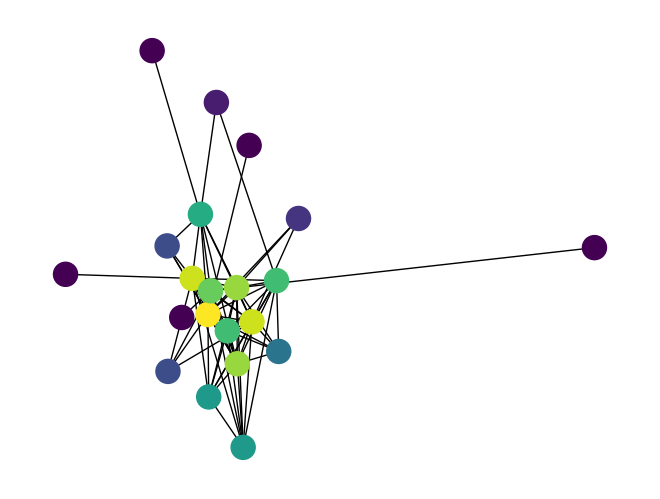

In [201]:
g_old = read_graph(path, is_add_new_nodes=False)
degrees = g_old.degree() #Dict with Node ID, Degree
nodes = g_old.nodes()
n_color = np.asarray([degrees[n] for n in nodes])

random_state = np.random.RandomState(42)
pos = nx.spring_layout(g_old, k=10/math.sqrt(g_old.order()), seed=random_state)
# pos = nx.circular_layout(g_old)
d = dict(g_old.degree)
node_size=[v * 100 for v in d.values()]
nx.draw(g_old,pos,nodelist=nodes,node_color=n_color)

## Introducing new animal in the Social Graph

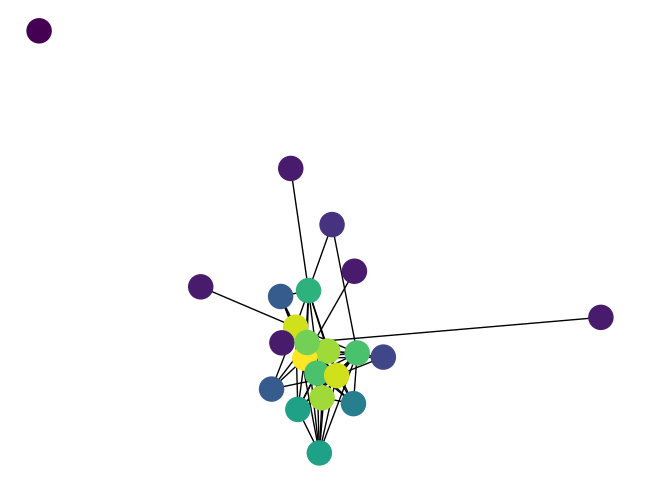

In [202]:
g_new = read_graph(path, is_add_new_nodes=True)

degrees = g_new.degree() #Dict with Node ID, Degree
nodes = g_new.nodes()

n_color = np.asarray([degrees[n] for n in nodes])


random_state = np.random.RandomState(42)
pos = nx.spring_layout(g_new, k=10/math.sqrt(g_old.order()), seed=random_state)
# pos = nx.circular_layout(g_new)
d = dict(g_new.degree)
node_size=[v * 100 for v in d.values()]

nx.draw(g_new,pos,nodelist=nodes,node_color=n_color)

In [203]:
new_idx = 0
for node, data in g_new.nodes(data=True):
    if node=="new_bat": 
        new_idx = node_dict[node]
        print("Found index of new node", new_idx)
        break


new_edges = []
for i, (pred, true) in enumerate(zip(preds[new_idx],adj_norm[new_idx])):
    
    if pred >= 0.5:
        
        name = [name for name, node_id in node_dict.items() if node_id==i][0]
        src_name = [name for name, node_id in node_dict.items() if node_id==new_idx][0]
        if name != "new_bat":
            print("More probability", pred)
            new_edges.append(("new_bat",name))
    else:
        print("~~ Less probability", pred)
        

Found index of new node 19
~~ Less probability tensor(0.3898)
~~ Less probability tensor(0.3939)
~~ Less probability tensor(0.4287)
~~ Less probability tensor(0.3756)
~~ Less probability tensor(0.4982)
~~ Less probability tensor(0.4293)
More probability tensor(0.5000)
~~ Less probability tensor(0.3813)
More probability tensor(0.5002)
~~ Less probability tensor(0.0692)
~~ Less probability tensor(0.5000)
~~ Less probability tensor(0.4878)
~~ Less probability tensor(0.4511)
~~ Less probability tensor(0.4198)
~~ Less probability tensor(0.3861)
~~ Less probability tensor(0.2486)
More probability tensor(0.5000)
~~ Less probability tensor(0.1822)
~~ Less probability tensor(0.4809)


In [204]:
new_edges

[('new_bat', 'helsing'), ('new_bat', 'fuschia'), ('new_bat', 'gomez')]

## Predicting the new edges for the new animal in the network

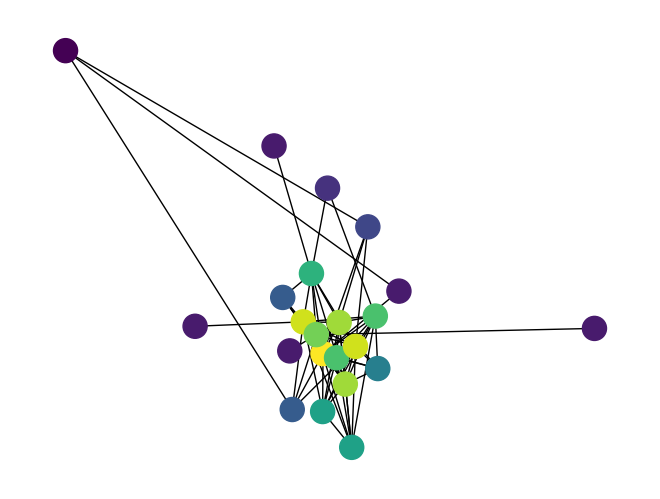

In [205]:
# g_new = read_graph(path, is_add_new_nodes=True)
degrees = g_new.degree() #Dict with Node ID, Degree
nodes = g_new.nodes()

n_color = np.asarray([degrees[n] for n in nodes])

g_new.add_edges_from(new_edges)
random_state = np.random.RandomState(42)
pos = nx.spring_layout(g_new, k=12/math.sqrt(g_old.order()), seed=random_state)
# pos = nx.circular_layout(g_new)
d = dict(g_new.degree)
node_size=[v * 100 for v in d.values()]
nx.draw(g_new,pos,nodelist=nodes,node_color=n_color)